In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
# classification: inputs (of images) -> outputs (probability of an image being in a class which can be used to give respective labels)

    #inputs: numerically encoded, outputs: prediction probabilities
    # general representation of image is a tensor: shape = [batch_size, color_channels, widht, height], may vary based on requirements

    # abstract architecture of a classification model
        # input_layer (in_features) number of features
        # hidden_layers: problem specific with minimum of 1
        # neurons_per hidde_layer: problem specific but generally varies between 4 to 512
        # output_layer (out_features): 1 per class
        # hidden_layer activation: usually ReLU but may be different baesd on the problem
        # output_layer activation: usually sigmoid for binary and softmax for multiclass classification
        # loss function: how wrong the predictions are from actual values and in general binary crossentropy for binary and cross entropy for multiclass classfiication are common options
        # optimizer: optimizes the values or predictions by adjusting weights and/or bias' in general, either SGD(stochastic gradient descent) or Adam

In [3]:
# sample data to explore classification
from sklearn.datasets import make_circles

sample_size = 1000

# create circles: each sample of X has respective label in y (either 0 or 1)
# two features of X predict one value of y
X, y = make_circles(sample_size, noise=0.03, random_state=32)

print(len(X), len(y))
print(X[:5]) # print 5  samples of X
print(y[:5]) # print samples of y
print(X.shape, y.shape)

1000 1000
[[-0.07257539  0.75564179]
 [-0.5195304   0.53377845]
 [-0.41659803 -0.69048017]
 [-0.64663454  0.67708664]
 [-0.48416281 -0.67039648]]
[1 1 1 0 1]
(1000, 2) (1000,)


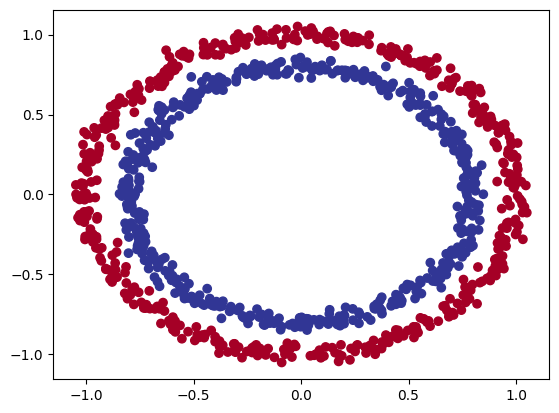

In [4]:
# convert circle data into dataframe
import pandas as pd
import matplotlib.pyplot as plt
circles = pd.DataFrame({"X1": X[:,0],
                                        "X2": X[:,1],
                                        "label": y})


circles.head(10)

plt.scatter(x=X[:, 0], y=X[:,1], c=y, cmap=plt.cm.RdYlBu)

In [5]:
# turn data intto tensors

if not isinstance(X, torch.Tensor):
    X = torch.from_numpy(X).type(torch.float)
if not isinstance(y, torch.Tensor):
    y = torch.from_numpy(y).type(torch.float)

print(X.shape, y.shape)
print(X[:5], y[:5])

torch.Size([1000, 2]) torch.Size([1000])
tensor([[-0.0726,  0.7556],
        [-0.5195,  0.5338],
        [-0.4166, -0.6905],
        [-0.6466,  0.6771],
        [-0.4842, -0.6704]]) tensor([1., 1., 1., 0., 1.])


In [6]:
from sklearn.model_selection import train_test_split

# split data into training and test sets
X_train, X_test, y_train,y_test = train_test_split(X, y, train_size=0.8, random_state=32)

print(len(X_train), len(X_test))

800 200


In [7]:
# use gpu if available
device = "cuda" if torch.cuda.is_available() else "cpu"


In [8]:
# simple model by subclassing nn.Module
import torch.nn.functional as F

class CircleClassificationModel(nn.Module):
    def __init__(self):
        super(CircleClassificationModel, self).__init__()

        self.layer_01 = nn.Linear(in_features=2, out_features=8)
        self.layer_02 = nn.Linear(in_features=8, out_features=1)

    # forward pass or forward propagation
    def forward(self, x):
        x = F.relu(self.layer_01(x))
        x = self.layer_02(x)
        return x


In [9]:
circle_classification_model = CircleClassificationModel().to(device)

In [10]:
# calculate accuracy : what percentage does the model get right
def accuracy(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    return (correct/len(y_pred)) * 100


In [11]:
# circle classification model using nn.Sequential
circle_classificiation_seq_model = nn.Sequential(
   nn.Linear(in_features=2, out_features=32),
   nn.ReLU(),
   nn.Linear(in_features=32, out_features=32),
   nn.ReLU(),
   nn.Linear(in_features=32, out_features=16),
   nn.ReLU(),
   nn.Linear(in_features=16, out_features=8),
   nn.ReLU(),
   nn.Linear(in_features=8, out_features=1)
).to(device)

# check parameters:
#circle_classificiation_seq_model.state_dict()

In [12]:
# training the model

num_epochs = 100 # number of training loops

# loss function:
criterion = nn.BCEWithLogitsLoss() # binary cross entropy loss with built-in sigmoid activation function
#optimizer = optim.SGD(circle_classificiation_seq_model.parameters(), lr=0.01)
optimizer = optim.Adam(circle_classificiation_seq_model.parameters(), lr=0.01)

for epoch in range(num_epochs):
    optimizer.zero_grad()

    circle_classificiation_seq_model.train()
    y_logits = circle_classificiation_seq_model(X_train).squeeze()
    train_predictions = torch.round(torch.sigmoid(y_logits))
    loss = criterion(y_logits, y_train)
    acc = accuracy(y_true=y_train, y_pred=train_predictions)
    loss.backward()
    optimizer.step()

    circle_classificiation_seq_model.eval()
    with torch.inference_mode():
        test_logits = circle_classificiation_seq_model(X_test).squeeze()
        test_preds = torch.round(torch.sigmoid(test_logits))

        test_loss = criterion(test_logits, test_preds)
        test_accuracy = accuracy(y_test, test_preds)

    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}%" )

Epoch: 0 | Loss: 0.69945, Acc: 48.25%
Epoch: 10 | Loss: 0.68219, Acc: 69.25%
Epoch: 20 | Loss: 0.55350, Acc: 93.88%
Epoch: 30 | Loss: 0.16450, Acc: 99.50%
Epoch: 40 | Loss: 0.02122, Acc: 100.00%
Epoch: 50 | Loss: 0.00454, Acc: 100.00%
Epoch: 60 | Loss: 0.00225, Acc: 100.00%
Epoch: 70 | Loss: 0.00135, Acc: 100.00%
Epoch: 80 | Loss: 0.00106, Acc: 100.00%
Epoch: 90 | Loss: 0.00090, Acc: 100.00%


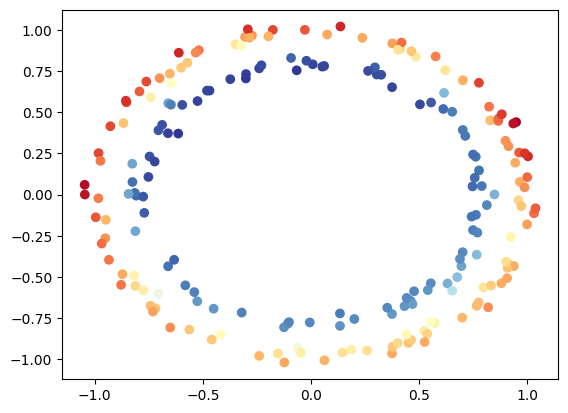

In [13]:
with torch.inference_mode():
    y_predictions = circle_classificiation_seq_model(X_test)

plt.scatter(x=X_test[:,0], y=X_test[:,1],c=y_predictions, cmap=plt.cm.RdYlBu)


In [14]:
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
    print("helper_fnuctions already exists, skipping download")
else:
    print("Downloading")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

Downloading


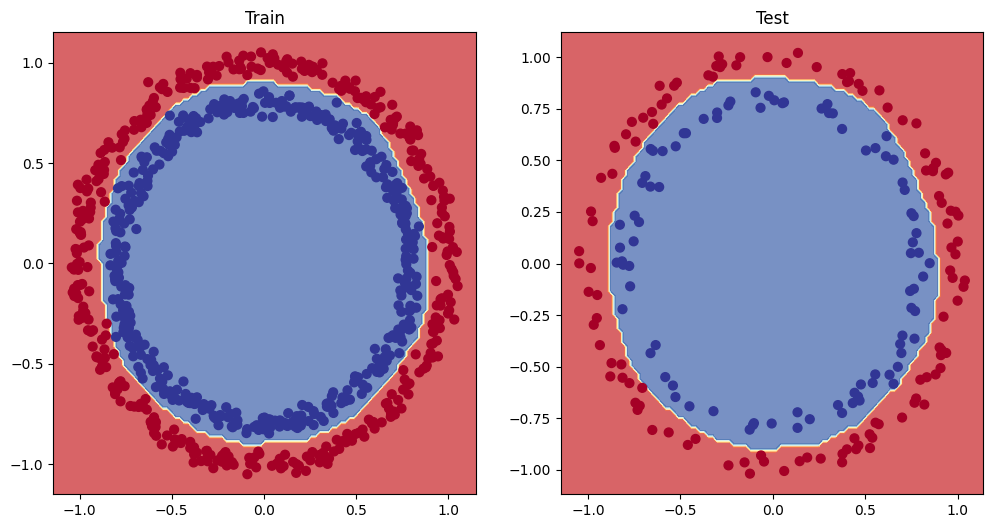

In [15]:
from helper_functions import plot_predictions, plot_decision_boundary

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(circle_classificiation_seq_model, X_train, y_train)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(circle_classificiation_seq_model, X_test, y_test)

In [16]:
()

()

In [17]:
class CirclePredictionV2(nn.Module):
    def __init__(self):
        super(CirclePredictionV2, self).__init__()
        self.layer_01 = nn.Linear(2, 32)
        self.layer_02 = nn.Linear(32, 32)
        self.layer_03 = nn.Linear(32, 1)
     #   self.layer_04 = nn.Linear(16, 16)
      #  self.layer_05 = nn.Linear(16, 1)

    def forward(self, x):
        a = F.relu(self.layer_01(x))
        a = F.relu(self.layer_02(a))
        a = F.relu(self.layer_03(a))
        #a = F.relu(self.layer_04(a))
        #a = F.relu(self.layer_05(a))
        return a


In [18]:
# training the model
circle_prediction_v2 = CirclePredictionV2()

num_epochs = 100 # number of training loops

# loss function:
criterion = nn.BCEWithLogitsLoss() # binary cross entropy loss with built-in sigmoid activation function
#optimizer = optim.SGD(circle_classificiation_seq_model.parameters(), lr=0.01)
optimizer = optim.Adam(circle_prediction_v2.parameters(), lr=0.01)

for epoch in range(num_epochs):
    optimizer.zero_grad()

    circle_classificiation_seq_model.train()
    y_logits = circle_prediction_v2(X_train).squeeze()
    train_predictions = torch.round(torch.sigmoid(y_logits))
    loss = criterion(y_logits, y_train)
    acc = accuracy(y_true=y_train, y_pred=train_predictions)
    loss.backward()
    optimizer.step()

    circle_prediction_v2.eval()
    with torch.inference_mode():
        test_logits = circle_prediction_v2(X_test).squeeze()
        test_preds = torch.round(torch.sigmoid(test_logits))

        test_loss = criterion(test_logits, test_preds)
        test_accuracy = accuracy(y_test, test_preds)

    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}%" )

Epoch: 0 | Loss: 0.69315, Acc: 48.25%
Epoch: 10 | Loss: 0.69315, Acc: 48.25%
Epoch: 20 | Loss: 0.69315, Acc: 48.25%
Epoch: 30 | Loss: 0.69315, Acc: 48.25%
Epoch: 40 | Loss: 0.69315, Acc: 48.25%
Epoch: 50 | Loss: 0.69315, Acc: 48.25%
Epoch: 60 | Loss: 0.69315, Acc: 48.25%
Epoch: 70 | Loss: 0.69315, Acc: 48.25%
Epoch: 80 | Loss: 0.69315, Acc: 48.25%
Epoch: 90 | Loss: 0.69315, Acc: 48.25%


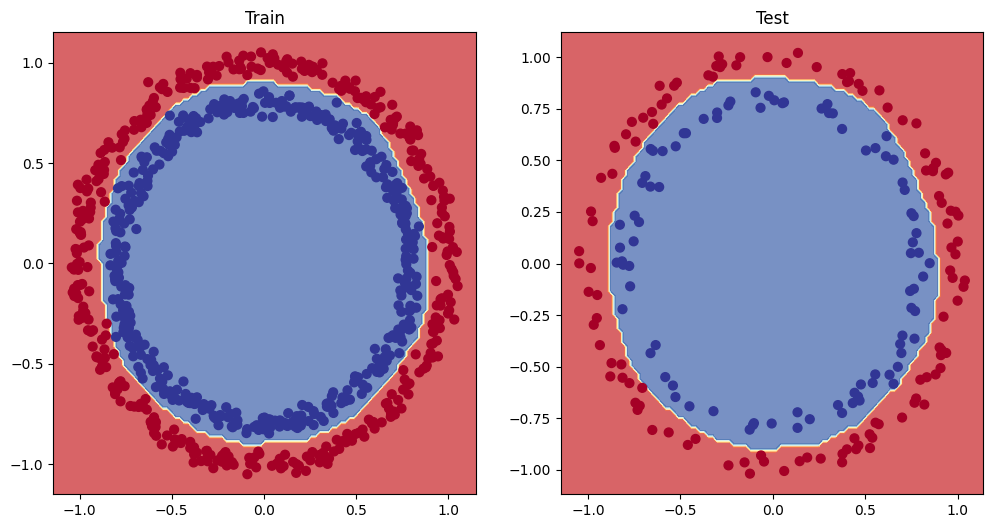

In [19]:
from helper_functions import plot_predictions, plot_decision_boundary

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(circle_classificiation_seq_model, X_train, y_train)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(circle_classificiation_seq_model, X_test, y_test)

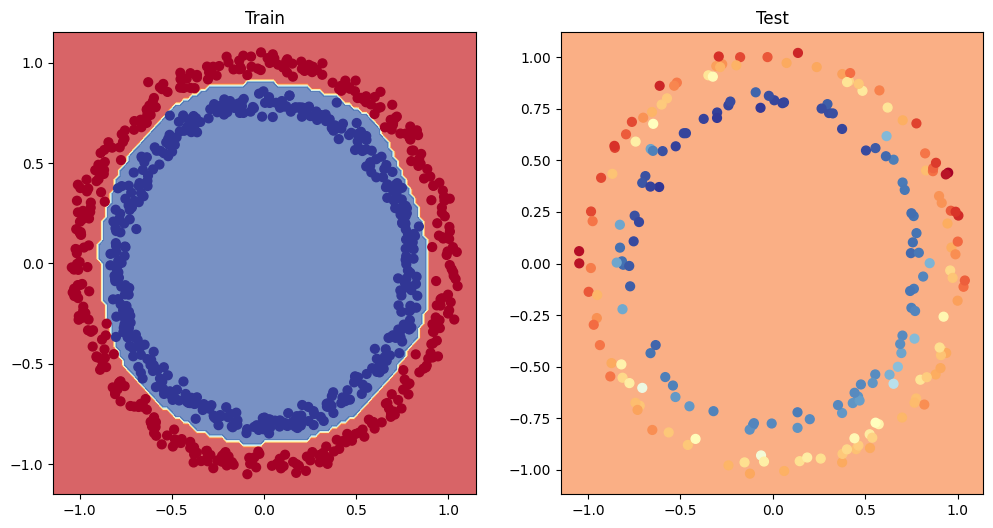

In [20]:
from helper_functions import plot_predictions, plot_decision_boundary

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(circle_classificiation_seq_model, X_train, y_train)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(circle_classificiation_seq_model, X_test, y_predictions)